# ex05
##### - Nakada Ryumei

In [3]:
#=
Solving the optimal growth problem via value function iteration.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date : 2014-07-05

References
----------

Simple port of the file quantecon.models.optgrowth

http://quant-econ.net/jl/dp_intro.html
=#

#=
    This type defines the primitives representing the growth model. The
    default values are

        f(k) = k**alpha, i.e, Cobb-Douglas production function
        u(c) = ln(c), i.e, log utility

    See the constructor below for details
=#
                
include("MyLinInterp.jl")
using Optim
using Colors
using Plots

"""
Neoclassical growth model

##### Fields

- `f::Function` : Production function
- `bet::Real` : Discount factor in (0, 1)
- `u::Function` : Utility function
- `grid_max::Int` : Maximum for grid over savings values
- `grid_size::Int` : Number of points in grid for savings values
- `grid::LinSpace{Float64}` : The grid for savings values

"""
type GrowthModel
    f::Function
    bet::Float64
    u::Function
    grid_max::Int
    grid_size::Int
    grid::LinSpace{Float64}
end


default_f(k) = k^0.65
default_u(c) = log(c)

"""
Constructor of `GrowthModel`

##### Arguments

- `f::Function(k->k^0.65)` : Production function
- `bet::Real(0.95)` : Discount factor in (0, 1)
- `u::Function(log)` : Utility function
- `grid_max::Int(2)` : Maximum for grid over savings values
- `grid_size::Int(150)` : Number of points in grid for savings values

"""
function GrowthModel(f=default_f, bet=0.95, u=default_u, grid_max=2, grid_size=150)
    grid = linspace(1e-6, grid_max, grid_size)
    return GrowthModel(f, bet, u, grid_max, grid_size, grid)
end

"""
Apply the Bellman operator for a given model and initial value.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output.
- `;ret_policy::Bool(false)`: Toggles return of value or policy functions

##### Returns

None, `out` is updated in place. If `ret_policy == true` out is filled with the
policy function, otherwise the value function is stored in `out`.

"""
function bellman_operator!(g::GrowthModel, w::Vector, out::Vector; ret_policy::Bool=false)
    # Apply linear interpolation to w
    Aw = MyLinInterp.LinearInterpolation(g.grid, w) 

    for (i, k) in enumerate(g.grid)
        objective(c) = - g.u(c) - g.bet * Aw(g.f(k) - c)
        res = optimize(objective, 1e-6, g.f(k))
        c_star = res.minimum

        if ret_policy
            # set the policy equal to the optimal c
            out[i] = c_star
        else
            # set Tw[i] equal to max_c { u(c) + beta w(f(k_i) - c)}
            out[i] = - objective(c_star)
        end
    end

    return out
end

function bellman_operator(g::GrowthModel, w::Vector; ret_policy::Bool=false)
    out = similar(w)
    bellman_operator!(g, w, out, ret_policy=ret_policy)
end

"""
Extract the greedy policy (policy function) of the model.

##### Arguments

- `g::GrowthModel` : Instance of `GrowthModel`
- `w::Vector`: Current guess for the value function
- `out::Vector` : Storage for output

##### Returns

None, `out` is updated in place to hold the policy function

"""
function get_greedy!(g::GrowthModel, w::Vector, out::Vector)
    bellman_operator!(g, w, out, ret_policy=true)
end

get_greedy(g::GrowthModel, w::Vector) = bellman_operator(g, w, ret_policy=true)


Use "(a::LinearInterpolation)(...)" instead.


get_greedy (generic function with 1 method)

In [4]:
#=
Compute the fixed point of a given operator T, starting from
specified initial condition v.

@author : Spencer Lyon <spencer.lyon@nyu.edu>

@date: 2014-07-05

References
----------

http://quant-econ.net/jl/dp_intro.html
=#


"""
Repeatedly apply a function to search for a fixed point

Approximates `T^∞ v`, where `T` is an operator (function) and `v` is an initial
guess for the fixed point. Will terminate either when `T^{k+1}(v) - T^k v <
err_tol` or `max_iter` iterations has been exceeded.

Provided that `T` is a contraction mapping or similar,  the return value will
be an approximation to the fixed point of `T`.

##### Arguments

* `T`: A function representing the operator `T`
* `v::TV`: The initial condition. An object of type `TV`
* `;err_tol(1e-3)`: Stopping tolerance for iterations
* `;max_iter(50)`: Maximum number of iterations
* `;verbose(2)`: Level of feedback (0 for no output, 1 for warnings only, 2
        for warning and convergence messages during iteration)
* `;print_skip(10)` : if `verbose == 2`, how many iterations to apply between
        print messages

##### Returns
---

* '::TV': The fixed point of the operator `T`. Has type `TV`

##### Example

```julia
using QuantEcon
T(x, μ) = 4.0 * μ * x * (1.0 - x)
x_star = compute_fixed_point(x->T(x, 0.3), 0.4)  # (4μ - 1)/(4μ)
```

"""
function compute_fixed_point{TV}(T::Function, 
                                v::TV; 
                                err_tol=1e-4,
                                max_iter=100, 
                                verbose=2, 
                                print_skip=10)

    if !(verbose in (0, 1, 2))
        throw(ArgumentError("verbose should be 0, 1 or 2"))
    end

    iterate = 0
    err = err_tol + 1
    while iterate < max_iter && err > err_tol
        new_v = T(v)::TV
        iterate += 1
        err = Base.maxabs(new_v - v)
        if verbose == 2
            if iterate % print_skip == 0
                println("Compute iterate $iterate with error $err")
            end
        end
        v = new_v
    end

    if verbose >= 1
        if iterate == max_iter
            warn("max_iter attained in compute_fixed_point")
        elseif verbose == 2
            println("Converged in $iterate steps")
        end
    end

    return v
end

compute_fixed_point

In [9]:
function main(gm, n::Int=35; show_fig = true)
    w_init = 5 .* log(gm.grid) .- 25  # An initial condition -- fairly arbitrary
    w = copy(w_init)
    
    ws = Array(Array, n)
    colors = Array(RGBA, 1, n)
    for i in 1:n
        w = bellman_operator(gm, w)
        ws[i] = w
        colors[i] = RGBA(i/n, 1-i/n, i/n, 1)
    end

    alpha = 0.65
    ab = alpha * gm.bet
    c1 = (log(1 - ab) + log(ab) * ab / (1 - ab)) / (1 - gm.bet)
    c2 = alpha / (1 - ab)
    v_star(k) = c1 .+ c2 .* log(k)

    if show_fig
        p = plot(gm.grid, w_init, color=:green, linewidth=2, alpha=0.6, label="initial condition")
        plot!(gm.grid, ws, color=colors, label="", linewidth=2)
        plot!(gm.grid, v_star(gm.grid), color=:blue, linewidth=2, alpha=0.8, label="true value function")
        plot!(ylims=(-40, -20), xlims=(minimum(gm.grid), maximum(gm.grid)))

        return p
    else
        return w
    end
end

main (generic function with 4 methods)

In [10]:
gm = GrowthModel()

GrowthModel(default_f,0.95,default_u,2,150,linspace(1.0e-6,2.0,150))

### 第一の図


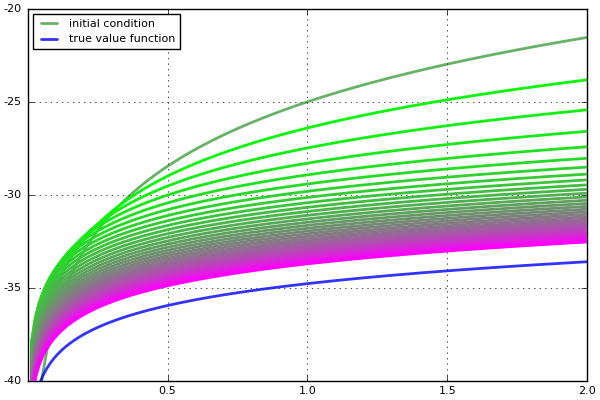

In [11]:
main(gm, 35)

### 第二の図


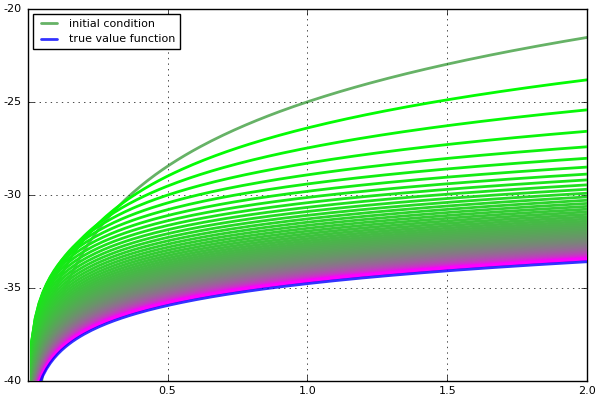

In [12]:
main(gm, 75)

## Exercise 1

In [14]:
alpha = 0.5
sigma = x -> (1 - alpha * gm.bet) * x ^ alpha

sigma(0.5)

0.3712310601229375


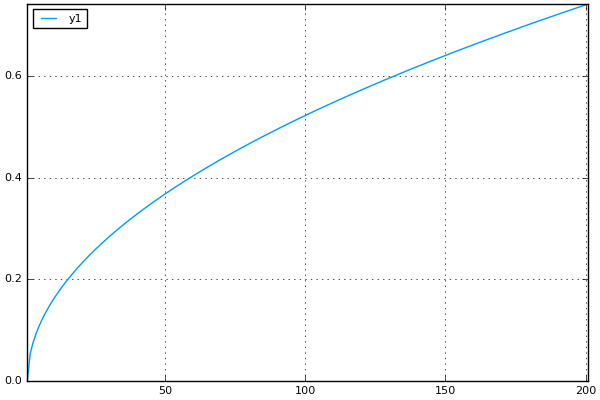

In [18]:
plot(map(sigma, 0:0.01:2))